# Creating sentiment prediction model

In [435]:
import pandas as pd
import numpy as np
import re 
import chardet
import gc
import bz2

In [436]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Dropout, LSTM
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

Import data

In [437]:
df = pd.read_csv('Data/reviews_clean.csv')

Sort the reviews by sentiment into 3 categories get dummies for the categorical classes.

In [439]:
def ternary_score(x):
    if x>3:
        return 'positive'
    elif x<3:
        return 'negative'
    else:
        return 'neutral'
X = df['StrippedComment'].astype(str)
y = pd.get_dummies(df['Score'].apply(ternary_score))
y

,negative,neutral,positive
0,1,0,0
1,1,0,0
2,1,0,0
3,0,0,1
4,0,1,0
...,...,...,...
5015,1,0,0
5016,0,0,1
5017,0,0,1
5018,1,0,0


Splitting the data into train and test datasets.

In [438]:
from sklearn.model_selection import train_test_split

In [459]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Tried to implement the GloVe model, however the dataset is too small for GloVe to make satisfactory predictions. 

In [460]:
f = open("TextForGloVe/amazon_train.txt", "w")
txt_data = ' '.join([i for i in X_train.to_list()])
f.write(txt_data)
f.close()

Defining maximum features, max length of the vectors.

In [497]:
max_features = 8863
SEQUENCE_LENGTH = 300

## Creating Word2Vec embeddings

In [462]:
from tqdm import tqdm
from gensim.models import Word2Vec 

Setting the required parameters, the vector size, the length of the window for model to go through and epochs

In [463]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 3

text = [_text.split() for _text in X_train]

Training W2V model on the overall train dataset

In [464]:
modelW2V = Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)
modelW2V.build_vocab(text)

modelW2V.train(text, total_examples = len(text), 
            epochs=W2V_EPOCH, report_delay=1)

(4813738, 5556736)

Finding out the vocab size

In [470]:
words = modelW2V.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 3813


In [471]:
print(modelW2V)
XW2V = modelW2V[modelW2V.wv.vocab]
XW2V.shape

Word2Vec(vocab=3813, size=300, alpha=0.025)


<ipython-input-471-8a8ed1116510>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  XW2V = modelW2V[modelW2V.wv.vocab]


(3813, 300)

## Preprocessing Data

Tokenizing the comments

In [465]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train.to_list())

In [466]:
tokenized_train = tokenizer.texts_to_sequences(X_train.to_list())
X_train = sequence.pad_sequences(tokenized_train, maxlen=SEQUENCE_LENGTH)
tokenized_test = tokenizer.texts_to_sequences(X_test.to_list())
X_test = sequence.pad_sequences(tokenized_test, maxlen=SEQUENCE_LENGTH)

Creating the embedding matrix

In [472]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in modelW2V.wv:
    embedding_matrix[i] = modelW2V.wv[word]
print(embedding_matrix.shape)

(8863, 300)


# Defining the model

In [505]:
model = Sequential()
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

(8863, 300)
50
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 300, 300)          2658900   
_________________________________________________________________
dropout_12 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                70200     
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 153       
Total params: 2,729,253
Trainable params: 70,353
Non-trainable params: 2,658,900
_________________________________________________________________


# Training the model

In [506]:
epochs = 7
batch_size = 128
callbacks =  [ReduceLROnPlateau(monitor='val_loss', patience=2, cooldown=0), EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=2)]
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks)

Epoch 1/7
22/22 [==============================] - 14s 624ms/step - loss: 0.9324 - accuracy: 0.6349 - val_loss: 0.7180 - val_accuracy: 0.7429
Epoch 2/7
22/22 [==============================] - 14s 621ms/step - loss: 0.6747 - accuracy: 0.7342 - val_loss: 0.6588 - val_accuracy: 0.7533
Epoch 3/7
22/22 [==============================] - 14s 627ms/step - loss: 0.5982 - accuracy: 0.7751 - val_loss: 0.5891 - val_accuracy: 0.7831
Epoch 4/7
22/22 [==============================] - 13s 590ms/step - loss: 0.5569 - accuracy: 0.7877 - val_loss: 0.5715 - val_accuracy: 0.8039
Epoch 5/7
22/22 [==============================] - 12s 564ms/step - loss: 0.5235 - accuracy: 0.8037 - val_loss: 0.5952 - val_accuracy: 0.7920
Epoch 6/7
22/22 [==============================] - 12s 554ms/step - loss: 0.5102 - accuracy: 0.8130 - val_loss: 0.5363 - val_accuracy: 0.8083
Epoch 7/7
22/22 [==============================] - 12s 557ms/step - loss: 0.4826 - accuracy: 0.8190 - val_loss: 0.6019 - val_accuracy: 0.7949


### Understanding the model performance

In [507]:
model_loss = pd.DataFrame(model.history.history)

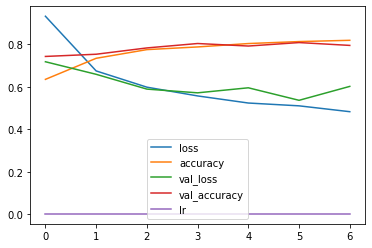

In [508]:
model_loss.plot()

## Analysing the model performance with respect to TextBlob predictions

In [511]:
import sklearn

In [513]:
from textblob import TextBlob

In [509]:
y_pred_model = model.predict(X_test)

In [510]:
labels = ['negative', 'neutral', 'positive']
y_pred_model = [labels[np.argmax(i)] for i in y_pred_model]
y_test['val'] = y_test.apply(lambda x: labels[np.argmax([x['negative'], x['neutral'], x['positive']])], axis=1)

<ipython-input-510-517d6fab804f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['val'] = y_test.apply(lambda x: labels[np.argmax([x['negative'], x['neutral'], x['positive']])], axis=1)


In [512]:
eval_model = sklearn.metrics.classification_report(y_test['val'].to_list(), y_pred_model, labels=['negative', 'neutral', 'positive'])

/Users/petrandreev/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Get sentiment scores from textBlob model

In [514]:
polarity = lambda x: TextBlob(x).sentiment.polarity
X_test['Polarity'] =  X_test.apply(polarity)

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [515]:
def get_sentiment(x):
    if x<0:
        return 'negative'
    elif x>0.4:
        return 'positive'
    else:
        return 'neutral'
X_test['Sentiment'] = X_test['Polarity'].apply(get_sentiment)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [516]:
eval_sent = sklearn.metrics.classification_report(y_test['val'].to_list(), X_test['Sentiment'].to_list(), labels=['negative', 'neutral', 'positive'])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Compare the F-1 score of textblob and my models

In [517]:
print(eval_model)
print(eval_sent)

              precision    recall  f1-score   support

    negative       0.72      0.67      0.69       440
     neutral       0.00      0.00      0.00       123
    positive       0.82      0.94      0.87      1094

    accuracy                           0.79      1657
   macro avg       0.51      0.53      0.52      1657
weighted avg       0.73      0.79      0.76      1657

              precision    recall  f1-score   support

    negative       0.66      0.28      0.39       440
     neutral       0.08      0.78      0.15       123
    positive       0.94      0.27      0.42      1094

    accuracy                           0.31      1657
   macro avg       0.56      0.44      0.32      1657
weighted avg       0.80      0.31      0.39      1657



# Saving the model

In [519]:
model.save_weights("Model Weights/SentimentAnalysisRingReviews.h5")